Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 11.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.8 MB/s 
     |████████████████████████████████| 120 kB 63.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=0b41bbd9d4eebee57dd64cc931c86a74bf9e90ebcd8f542f13026de813180e60
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

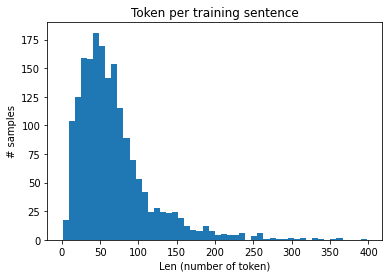

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

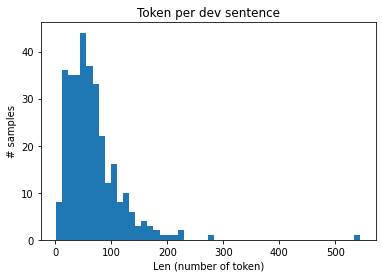

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

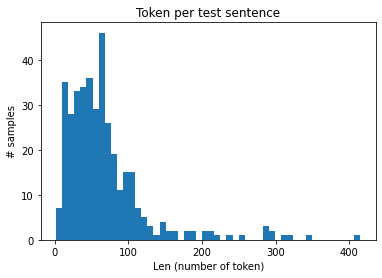

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

943
aporte
0
B-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.7248)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 500
Points in y_train before removal: 500


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[3603, 1792, 5352, 7601, 12682, 673, 1792, 10512, 7601, 13485, 1425, 9191, 7187, 9191, 5229, 7215, 10786, 13485, 1280, 13485, 9968, 7579, 8654, 2116, 3313, 7328, 6493, 10148, 7909, 9191, 13485, 5557, 7582]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1]
[10095, 6927, 9191, 362, 2443, 8184, 10313, 7755, 11095, 13485, 8317, 4788, 3183, 9825, 7236, 13485, 12982, 13485, 1757, 10524, 9191, 12145, 1795, 4023, 13247, 673, 3981, 4197, 12588, 13485, 3707, 1716, 3374, 2067, 13063, 11929, 5131, 2974, 13485, 346, 738, 3981, 6846, 9191, 3981, 5530, 9191, 10635, 4589, 3981, 3937, 1653, 7215, 10864, 2570, 8807, 10339, 2116, 7509, 5960, 9191, 4887, 9191, 2570, 6493, 6415, 8654, 7509, 2767, 2570, 6493, 12358, 4589, 7509, 3790, 1792, 3950, 7582, 248]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 0, 

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 35.4 MB/s 
     |████████████████████████████████| 120 kB 52.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=39b54a9d344a2f2c64130374fe675f8a6cdded48347831ff03b436e7b41e099b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[3603, 1792, 5352, 7601, 12682, 673, 1792, 10512, 7601, 1348

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.091054916381836
Training loss epoch: 0.19088812987320125
Training accuracy epoch: 0.9356069175962956
Validating model...
Validation Loss: 0.04953494508351598
Validation Accuracy: 0.9860800995568239
Training epoch: 2
Training loss per 100 training steps: 0.03484354913234711
Training loss epoch: 0.03346627466089558
Training accuracy epoch: 0.9907712932659961
Validating model...
Validation Loss: 0.020456716795230194
Validation Accuracy: 0.9940452723249706
Training epoch: 3
Training loss per 100 training steps: 0.023210344836115837
Training loss epoch: 0.016946986288530752
Training accuracy epoch: 0.9944440346634479
Validating model...
Validation Loss: 0.01716121061084171
Validation Accuracy: 0.9955697370223061
Training epoch: 4
Training loss per 100 training steps: 0.01886160857975483
Training loss epoch: 0.011693226791976485
Training accuracy epoch: 0.9961255045145778
Validating model...
Validation Loss: 0.01780963531997432
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019344721707360197
Validation Accuracy: 0.9950810843234333
Validation duration: 0.1254913833333338 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0755796432495117
Training loss epoch: 0.19271211849991232
Training accuracy epoch: 0.9337069147470592
Validating model...
Validation Loss: 0.043874279728957584
Validation Accuracy: 0.987080834539717
Training epoch: 2
Training loss per 100 training steps: 0.0256460290402174
Training loss epoch: 0.029196052491897717
Training accuracy epoch: 0.991566446775037
Validating model...
Validation Loss: 0.02691118088772609
Validation Accuracy: 0.9919042842512976
Training epoch: 3
Training loss per 100 training steps: 0.03142554312944412
Training loss epoch: 0.018884212273405865
Training accuracy epoch: 0.9946844445791009
Validating model...
Validation Loss: 0.01905972507804455
Validation Accuracy: 0.9947340901803192
Training epoch: 4
Training loss per 100 training steps: 0.008927624672651291
Training loss epoch: 0.009144464385826723
Training accuracy epoch: 0.9973332355446981
Validating model...
Validation Loss: 0.021735401679983453
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021661021281033754
Validation Accuracy: 0.9940426264040724
Validation duration: 0.12679415000000063 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1672917604446411
Training loss epoch: 0.19176765228621662
Training accuracy epoch: 0.9323766499020678
Validating model...
Validation Loss: 0.045580435632949785
Validation Accuracy: 0.9876903944918206
Training epoch: 2
Training loss per 100 training steps: 0.05504687502980232
Training loss epoch: 0.030216131679480895
Training accuracy epoch: 0.9911465760088334
Validating model...
Validation Loss: 0.027621328919416384
Validation Accuracy: 0.9919052730277451
Training epoch: 3
Training loss per 100 training steps: 0.057608962059020996
Training loss epoch: 0.015900668004178442
Training accuracy epoch: 0.9955478395891555
Validating model...
Validation Loss: 0.025462650280955824
Validation Accuracy: 0.9926138575004605
Training epoch: 4
Training loss per 100 training steps: 0.005781781394034624
Training loss epoch: 0.009939129053236684
Training accuracy epoch: 0.9971679734148342
Validating model...
Validation Loss: 0.017062794223117333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021352787768895116
Validation Accuracy: 0.9951096655031978
Validation duration: 0.12559506666666684 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1285561323165894
Training loss epoch: 0.1787592397959088
Training accuracy epoch: 0.9360273529084188
Validating model...
Validation Loss: 0.04100645346833127
Validation Accuracy: 0.9869010498580356
Training epoch: 2
Training loss per 100 training steps: 0.019907766953110695
Training loss epoch: 0.030147168872645125
Training accuracy epoch: 0.9910608282836142
Validating model...
Validation Loss: 0.02817603144129472
Validation Accuracy: 0.9914788461515814
Training epoch: 3
Training loss per 100 training steps: 0.014040974900126457
Training loss epoch: 0.012082914199709194
Training accuracy epoch: 0.9964677621984902
Validating model...
Validation Loss: 0.01641703369317665
Validation Accuracy: 0.9957146963089989
Training epoch: 4
Training loss per 100 training steps: 0.006471454631537199
Training loss epoch: 0.00644851359538734
Training accuracy epoch: 0.9984104943135398
Validating model...
Validation Loss: 0.021924826553523808
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019440770765262034
Validation Accuracy: 0.9950561496910973
Validation duration: 0.1255352499999996 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1643168926239014
Training loss epoch: 0.2114542128983885
Training accuracy epoch: 0.9293316245280726
Validating model...
Validation Loss: 0.03926419386906283
Validation Accuracy: 0.98959333847413
Training epoch: 2
Training loss per 100 training steps: 0.07181069254875183
Training loss epoch: 0.03438920599000994
Training accuracy epoch: 0.9900124592335069
Validating model...
Validation Loss: 0.02558033840198602
Validation Accuracy: 0.9926619165077549
Training epoch: 3
Training loss per 100 training steps: 0.0111398259177804
Training loss epoch: 0.018348280027566943
Training accuracy epoch: 0.9950226164632607
Validating model...
Validation Loss: 0.01886627805652097
Validation Accuracy: 0.9947584475448394
Training epoch: 4
Training loss per 100 training steps: 0.010097978636622429
Training loss epoch: 0.00806780120183248
Training accuracy epoch: 0.9976543366472833
Validating model...
Validation Loss: 0.023258895753228682
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02101454167132033
Validation Accuracy: 0.9953588222056053
Validation duration: 0.1251881833333338 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.035972237586975
Training loss epoch: 0.1779892886406742
Training accuracy epoch: 0.9352706753278686
Validating model...
Validation Loss: 0.03170677946902634
Validation Accuracy: 0.9906638186746629
Training epoch: 2
Training loss per 100 training steps: 0.023978987708687782
Training loss epoch: 0.02488694824569393
Training accuracy epoch: 0.9931056503173408
Validating model...
Validation Loss: 0.024719319195442256
Validation Accuracy: 0.9936650649790818
Training epoch: 3
Training loss per 100 training steps: 0.010275072418153286
Training loss epoch: 0.01282907696077018
Training accuracy epoch: 0.9960611641708574
Validating model...
Validation Loss: 0.021429604207653375
Validation Accuracy: 0.9934482998302401
Training epoch: 4
Training loss per 100 training steps: 0.004704355262219906
Training loss epoch: 0.011611749683652306
Training accuracy epoch: 0.9974396314090613
Validating model...
Validation Loss: 0.024069775161305665
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019074935393291526
Validation Accuracy: 0.9955019291487391
Validation duration: 0.12502305000000055 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0800755023956299
Training loss epoch: 0.21772112336475402
Training accuracy epoch: 0.9241106977798511
Validating model...
Validation Loss: 0.050279417247067956
Validation Accuracy: 0.9842199409999359
Training epoch: 2
Training loss per 100 training steps: 0.03185514733195305
Training loss epoch: 0.03288001852342859
Training accuracy epoch: 0.991027401631962
Validating model...
Validation Loss: 0.028829928635830237
Validation Accuracy: 0.9921022729221987
Training epoch: 3
Training loss per 100 training steps: 0.006282411515712738
Training loss epoch: 0.020607472306437558
Training accuracy epoch: 0.9940915989851031
Validating model...
Validation Loss: 0.023351816593536308
Validation Accuracy: 0.9933807406317209
Training epoch: 4
Training loss per 100 training steps: 0.013407002203166485
Training loss epoch: 0.01018865382502554
Training accuracy epoch: 0.9969346777746829
Validating model...
Validation Loss: 0.017949902239100386
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.022639142349362373
Validation Accuracy: 0.994302191898507
Validation duration: 0.12454056666666323 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9957213401794434
Training loss epoch: 0.17029603943228722
Training accuracy epoch: 0.9404920669518402
Validating model...
Validation Loss: 0.040895057132556326
Validation Accuracy: 0.9882888904104938
Training epoch: 2
Training loss per 100 training steps: 0.032660845667123795
Training loss epoch: 0.027744476872612722
Training accuracy epoch: 0.9927010552724086
Validating model...
Validation Loss: 0.03160020041589936
Validation Accuracy: 0.9905714954910684
Training epoch: 3
Training loss per 100 training steps: 0.016972092911601067
Training loss epoch: 0.015178088320681127
Training accuracy epoch: 0.9956700854807795
Validating model...
Validation Loss: 0.024091392975865995
Validation Accuracy: 0.9928923952407137
Training epoch: 4
Training loss per 100 training steps: 0.01455221138894558
Training loss epoch: 0.008345820233444101
Training accuracy epoch: 0.9978536297812577
Validating model...
Validation Loss: 0.02001308823431221
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.024926970630379703
Validation Accuracy: 0.9948506528046833
Validation duration: 0.12558788333333268 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3596752882003784
Training loss epoch: 0.23240528511814773
Training accuracy epoch: 0.9165989825570018
Validating model...
Validation Loss: 0.050310899769621234
Validation Accuracy: 0.984172130239516
Training epoch: 2
Training loss per 100 training steps: 0.02986336499452591
Training loss epoch: 0.034100790187949315
Training accuracy epoch: 0.9903002889744844
Validating model...
Validation Loss: 0.01949882734056917
Validation Accuracy: 0.9944215583819314
Training epoch: 3
Training loss per 100 training steps: 0.0228726826608181
Training loss epoch: 0.016922127528232522
Training accuracy epoch: 0.9951733067835218
Validating model...
Validation Loss: 0.020397519234046785
Validation Accuracy: 0.9947871122997434
Training epoch: 4
Training loss per 100 training steps: 0.004172996152192354
Training loss epoch: 0.010043981212220388
Training accuracy epoch: 0.9969716142310677
Validating model...
Validation Loss: 0.017399884186618562
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019998367119114846
Validation Accuracy: 0.9951332564575459
Validation duration: 0.12373921666666471 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0616101026535034
Training loss epoch: 0.20702021865872666
Training accuracy epoch: 0.9317072244996318
Validating model...
Validation Loss: 0.03820556796909798
Validation Accuracy: 0.9885707065404264
Training epoch: 2
Training loss per 100 training steps: 0.04648733139038086
Training loss epoch: 0.03368726835469715
Training accuracy epoch: 0.990313775121433
Validating model...
Validation Loss: 0.024158008862286806
Validation Accuracy: 0.9929276568889681
Training epoch: 3
Training loss per 100 training steps: 0.03877823054790497
Training loss epoch: 0.017868417853605933
Training accuracy epoch: 0.9948460095658012
Validating model...
Validation Loss: 0.01987177299590604
Validation Accuracy: 0.9948656787377465
Training epoch: 4
Training loss per 100 training steps: 0.005557503551244736
Training loss epoch: 0.014151057563140057
Training accuracy epoch: 0.9960197190402368
Validating model...
Validation Loss: 0.018550571287050843
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02266169193899259
Validation Accuracy: 0.9945718499297586
Validation duration: 0.12394548333333356 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.203539490699768
Training loss epoch: 0.16772393515566364
Training accuracy epoch: 0.9385818098532791
Validating model...
Validation Loss: 0.03256840169584999
Validation Accuracy: 0.9906641735648194
Training epoch: 2
Training loss per 100 training steps: 0.03853680193424225
Training loss epoch: 0.02964229304343462
Training accuracy epoch: 0.991090512081521
Validating model...
Validation Loss: 0.02903969900771266
Validation Accuracy: 0.991047033350849
Training epoch: 3
Training loss per 100 training steps: 0.036525238305330276
Training loss epoch: 0.015437899381504394
Training accuracy epoch: 0.9954768449977134
Validating model...
Validation Loss: 0.01829850150915306
Validation Accuracy: 0.9954470638663752
Training epoch: 4
Training loss per 100 training steps: 0.006446774583309889
Training loss epoch: 0.007971924697631038
Training accuracy epoch: 0.9976635721460401
Validating model...
Validation Loss: 0.021952516862213434
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02355969427662785
Validation Accuracy: 0.994244907976564
Validation duration: 0.123744666666668 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1458547115325928
Training loss epoch: 0.17708390732877888
Training accuracy epoch: 0.936164893831401
Validating model...
Validation Loss: 0.040501229287613
Validation Accuracy: 0.9877827441638584
Training epoch: 2
Training loss per 100 training steps: 0.03351868689060211
Training loss epoch: 0.029905680601950736
Training accuracy epoch: 0.9912945428413302
Validating model...
Validation Loss: 0.024960187840319815
Validation Accuracy: 0.9922366802543036
Training epoch: 3
Training loss per 100 training steps: 0.018954062834382057
Training loss epoch: 0.018498686072416604
Training accuracy epoch: 0.9944190398167805
Validating model...
Validation Loss: 0.022589586486685135
Validation Accuracy: 0.9936751741564888
Training epoch: 4
Training loss per 100 training steps: 0.005341190844774246
Training loss epoch: 0.012631422613048926
Training accuracy epoch: 0.9957867082619447
Validating model...
Validation Loss: 0.025915048561901563
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02694943561315692
Validation Accuracy: 0.9946771455417549
Validation duration: 0.12411533333332349 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2248177528381348
Training loss epoch: 0.18634797271806747
Training accuracy epoch: 0.9328496754046377
Validating model...
Validation Loss: 0.06757648657297805
Validation Accuracy: 0.9771117094234963
Training epoch: 2
Training loss per 100 training steps: 0.029253438115119934
Training loss epoch: 0.03535601897165179
Training accuracy epoch: 0.9888682428927968
Validating model...
Validation Loss: 0.038244401631388994
Validation Accuracy: 0.988967275806495
Training epoch: 3
Training loss per 100 training steps: 0.02454550564289093
Training loss epoch: 0.01998063464416191
Training accuracy epoch: 0.9937682612359946
Validating model...
Validation Loss: 0.04332371769885954
Validation Accuracy: 0.9881582103765115
Training epoch: 4
Training loss per 100 training steps: 0.01251867413520813
Training loss epoch: 0.01878220506478101
Training accuracy epoch: 0.9949457416579868
Validating model...
Validation Loss: 0.024539096929532076
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02230226572767909
Validation Accuracy: 0.9949820758409896
Validation duration: 0.1255223166666686 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0853006839752197
Training loss epoch: 0.18389344473835081
Training accuracy epoch: 0.9343435094065924
Validating model...
Validation Loss: 0.033412156715279535
Validation Accuracy: 0.9912062532131067
Training epoch: 2
Training loss per 100 training steps: 0.04087663069367409
Training loss epoch: 0.029247854952700436
Training accuracy epoch: 0.991420502797372
Validating model...
Validation Loss: 0.029098847293339315
Validation Accuracy: 0.9904317218136796
Training epoch: 3
Training loss per 100 training steps: 0.02088865637779236
Training loss epoch: 0.015630996336403767
Training accuracy epoch: 0.9955215377453419
Validating model...
Validation Loss: 0.024540609053690873
Validation Accuracy: 0.9938566966195941
Training epoch: 4
Training loss per 100 training steps: 0.004493527114391327
Training loss epoch: 0.00829457835498033
Training accuracy epoch: 0.9978483761471184
Validating model...
Validation Loss: 0.024959503118658348
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02318943309849904
Validation Accuracy: 0.99431012173544
Validation duration: 0.12573464999998882 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.14884614944458
Training loss epoch: 0.17584334877319635
Training accuracy epoch: 0.939661491593168
Validating model...
Validation Loss: 0.0372722228279426
Validation Accuracy: 0.9893794898938156
Training epoch: 2
Training loss per 100 training steps: 0.017162201926112175
Training loss epoch: 0.03260776264360175
Training accuracy epoch: 0.9904773350874295
Validating model...
Validation Loss: 0.028661766355591162
Validation Accuracy: 0.9912467978607973
Training epoch: 3
Training loss per 100 training steps: 0.008756175637245178
Training loss epoch: 0.016437113480060363
Training accuracy epoch: 0.9955042355983335
Validating model...
Validation Loss: 0.02355050111682864
Validation Accuracy: 0.9932341840415555
Training epoch: 4
Training loss per 100 training steps: 0.006058104801923037
Training loss epoch: 0.013270147511502729
Training accuracy epoch: 0.9959762246575596
Validating model...
Validation Loss: 0.025954031377165978
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0225659401427644
Validation Accuracy: 0.9949252232278328
Validation duration: 0.12394214999999349 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.070215106010437
Training loss epoch: 0.17533333324827255
Training accuracy epoch: 0.9413817073613521
Validating model...
Validation Loss: 0.032148239613022836
Validation Accuracy: 0.9898456699999585
Training epoch: 2
Training loss per 100 training steps: 0.02403460629284382
Training loss epoch: 0.028002376039512455
Training accuracy epoch: 0.9915915992162919
Validating model...
Validation Loss: 0.02844125325680666
Validation Accuracy: 0.9905212419914539
Training epoch: 3
Training loss per 100 training steps: 0.01205896120518446
Training loss epoch: 0.01468144632235635
Training accuracy epoch: 0.9958977223973091
Validating model...
Validation Loss: 0.02459207011131747
Validation Accuracy: 0.993990654683764
Training epoch: 4
Training loss per 100 training steps: 0.0012248627608641982
Training loss epoch: 0.008974918950116262
Training accuracy epoch: 0.9977912909729086
Validating model...
Validation Loss: 0.02312602717678861
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.022480415316143382
Validation Accuracy: 0.9948703333135184
Validation duration: 0.12537828333333892 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1195495128631592
Training loss epoch: 0.1688311928184703
Training accuracy epoch: 0.9413226501385795
Validating model...
Validation Loss: 0.029522716866007874
Validation Accuracy: 0.9909124122924835
Training epoch: 2
Training loss per 100 training steps: 0.017955858260393143
Training loss epoch: 0.028581839194521307
Training accuracy epoch: 0.9915016483411806
Validating model...
Validation Loss: 0.020991014117108926
Validation Accuracy: 0.9935466480447447
Training epoch: 3
Training loss per 100 training steps: 0.012678703293204308
Training loss epoch: 0.020614506292622535
Training accuracy epoch: 0.9939127397190827
Validating model...
Validation Loss: 0.028618711662212654
Validation Accuracy: 0.991314081167024
Training epoch: 4
Training loss per 100 training steps: 0.00816656555980444
Training loss epoch: 0.010780235243146308
Training accuracy epoch: 0.9968193890108299
Validating model...
Validation Loss: 0.019662666517043754
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023669187789588857
Validation Accuracy: 0.9939126008816972
Validation duration: 0.12588363333332683 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0159225463867188
Training loss epoch: 0.1608992232941091
Training accuracy epoch: 0.9459827391304184
Validating model...
Validation Loss: 0.03450339926140649
Validation Accuracy: 0.9906393853933887
Training epoch: 2
Training loss per 100 training steps: 0.03297761455178261
Training loss epoch: 0.033616003673523666
Training accuracy epoch: 0.9907662339261434
Validating model...
Validation Loss: 0.02265549002636579
Validation Accuracy: 0.9930493546459263
Training epoch: 3
Training loss per 100 training steps: 0.030500084161758423
Training loss epoch: 0.019578754052054136
Training accuracy epoch: 0.9946110914121224
Validating model...
Validation Loss: 0.024289551931100765
Validation Accuracy: 0.9930516440393198
Training epoch: 4
Training loss per 100 training steps: 0.008746824227273464
Training loss epoch: 0.014107298833550885
Training accuracy epoch: 0.9963275574144316
Validating model...
Validation Loss: 0.026521176767779424
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.026846135093364865
Validation Accuracy: 0.9947885086199805
Validation duration: 0.12526413333333342 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8760989904403687
Training loss epoch: 0.1447457021102309
Training accuracy epoch: 0.9553612179838495
Validating model...
Validation Loss: 0.05391983756618131
Validation Accuracy: 0.9844814166584408
Training epoch: 2
Training loss per 100 training steps: 0.061697058379650116
Training loss epoch: 0.02771084043197334
Training accuracy epoch: 0.9920831877930645
Validating model...
Validation Loss: 0.028347094033268235
Validation Accuracy: 0.9912246297936158
Training epoch: 3
Training loss per 100 training steps: 0.043571341782808304
Training loss epoch: 0.013477049936773256
Training accuracy epoch: 0.9960578159369383
Validating model...
Validation Loss: 0.021459583126540695
Validation Accuracy: 0.9953148504139105
Training epoch: 4
Training loss per 100 training steps: 0.0031466411892324686
Training loss epoch: 0.006790843739145203
Training accuracy epoch: 0.9980113979586953
Validating model...
Validation Loss: 0.019896477280348164
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023724768584846363
Validation Accuracy: 0.9946349748286791
Validation duration: 0.127112966666679 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1891779899597168
Training loss epoch: 0.18041713428683578
Training accuracy epoch: 0.9364978423998199
Validating model...
Validation Loss: 0.034285157885668535
Validation Accuracy: 0.9904924115192809
Training epoch: 2
Training loss per 100 training steps: 0.059423450380563736
Training loss epoch: 0.030030273483134806
Training accuracy epoch: 0.9910960226698048
Validating model...
Validation Loss: 0.027875574372176613
Validation Accuracy: 0.9932183284265738
Training epoch: 3
Training loss per 100 training steps: 0.014152534306049347
Training loss epoch: 0.01637262448784895
Training accuracy epoch: 0.9952449181693585
Validating model...
Validation Loss: 0.02167230708402626
Validation Accuracy: 0.994419537049229
Training epoch: 4
Training loss per 100 training steps: 0.004552672151476145
Training loss epoch: 0.008710710045124869
Training accuracy epoch: 0.997572297302804
Validating model...
Validation Loss: 0.023612512375361154
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0276816716286703
Validation Accuracy: 0.994117501737455
Validation duration: 0.12380771666666987 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.963379979133606
Training loss epoch: 0.14438802740992385
Training accuracy epoch: 0.9526456910117794
Validating model...
Validation Loss: 0.03513611147978476
Validation Accuracy: 0.9898088211023774
Training epoch: 2
Training loss per 100 training steps: 0.06919345259666443
Training loss epoch: 0.02515410309895239
Training accuracy epoch: 0.9926823227559309
Validating model...
Validation Loss: 0.028041804015326004
Validation Accuracy: 0.9907789341853163
Training epoch: 3
Training loss per 100 training steps: 0.01026142667979002
Training loss epoch: 0.012786869294049734
Training accuracy epoch: 0.9962194753020549
Validating model...
Validation Loss: 0.021314993369049347
Validation Accuracy: 0.9941477207102923
Training epoch: 4
Training loss per 100 training steps: 0.006471327971667051
Training loss epoch: 0.009248347425377591
Training accuracy epoch: 0.9974799028895354
Validating model...
Validation Loss: 0.025554048458746235
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023824843124505907
Validation Accuracy: 0.9951026410692391
Validation duration: 0.1256472166666602 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.201405644416809
Training loss epoch: 0.14715310118775418
Training accuracy epoch: 0.9460426200378721
Validating model...
Validation Loss: 0.029596031854106558
Validation Accuracy: 0.9905887691625663
Training epoch: 2
Training loss per 100 training steps: 0.02145112305879593
Training loss epoch: 0.027908370691411038
Training accuracy epoch: 0.9916748142762561
Validating model...
Validation Loss: 0.023171333795679466
Validation Accuracy: 0.9927494570261698
Training epoch: 3
Training loss per 100 training steps: 0.01054360531270504
Training loss epoch: 0.016943265872195044
Training accuracy epoch: 0.9951585754190108
Validating model...
Validation Loss: 0.021432466712126154
Validation Accuracy: 0.9948051548560929
Training epoch: 4
Training loss per 100 training steps: 0.0035737440921366215
Training loss epoch: 0.00850412788047911
Training accuracy epoch: 0.9977940746318005
Validating model...
Validation Loss: 0.01882958677985395
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021700365493112866
Validation Accuracy: 0.9953723591091662
Validation duration: 0.12713399999999334 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2192926406860352
Training loss epoch: 0.17691913278813057
Training accuracy epoch: 0.9384614054877802
Validating model...
Validation Loss: 0.04076206351497343
Validation Accuracy: 0.9866103571208016
Training epoch: 2
Training loss per 100 training steps: 0.0956588089466095
Training loss epoch: 0.030909145885008447
Training accuracy epoch: 0.9911282756885719
Validating model...
Validation Loss: 0.022689381603240258
Validation Accuracy: 0.9923783427190143
Training epoch: 3
Training loss per 100 training steps: 0.016451425850391388
Training loss epoch: 0.016128604124458705
Training accuracy epoch: 0.9952625721028578
Validating model...
Validation Loss: 0.02960806653746182
Validation Accuracy: 0.9924774352939674
Training epoch: 4
Training loss per 100 training steps: 0.01365190465003252
Training loss epoch: 0.011519113411889114
Training accuracy epoch: 0.9966674553677309
Validating model...
Validation Loss: 0.024584854423578474
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023920775080720585
Validation Accuracy: 0.9937134174053864
Validation duration: 0.12391105000000001 minutes
F1-score (test): 94.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9248775243759155
Training loss epoch: 0.1349852703353192
Training accuracy epoch: 0.9572564066451571
Validating model...
Validation Loss: 0.03142268768334318
Validation Accuracy: 0.9906340678440899
Training epoch: 2
Training loss per 100 training steps: 0.0311585683375597
Training loss epoch: 0.023397860533379493
Training accuracy epoch: 0.9932722643438915
Validating model...
Validation Loss: 0.022704593604430556
Validation Accuracy: 0.9935677580915888
Training epoch: 3
Training loss per 100 training steps: 0.00636000232771039
Training loss epoch: 0.012249869906264258
Training accuracy epoch: 0.9966062669457855
Validating model...
Validation Loss: 0.019625699828750277
Validation Accuracy: 0.9946756082801498
Training epoch: 4
Training loss per 100 training steps: 0.004070750903338194
Training loss epoch: 0.0072113738935242625
Training accuracy epoch: 0.9977469652217341
Validating model...
Validation Loss: 0.027101355746188865
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023082260066682164
Validation Accuracy: 0.9939322745659721
Validation duration: 0.12588571666668333 minutes
F1-score (test): 95.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1720807552337646
Training loss epoch: 0.1609560998275559
Training accuracy epoch: 0.943496606144562
Validating model...
Validation Loss: 0.0359278104622804
Validation Accuracy: 0.9893591848701042
Training epoch: 2
Training loss per 100 training steps: 0.024391185492277145
Training loss epoch: 0.0267326017802066
Training accuracy epoch: 0.992723116065479
Validating model...
Validation Loss: 0.030416457836205762
Validation Accuracy: 0.9904473838056758
Training epoch: 3
Training loss per 100 training steps: 0.007635925430804491
Training loss epoch: 0.013928099872266992
Training accuracy epoch: 0.996031582519698
Validating model...
Validation Loss: 0.025156461639285442
Validation Accuracy: 0.9934569023788827
Training epoch: 4
Training loss per 100 training steps: 0.006700446363538504
Training loss epoch: 0.008673628219997788
Training accuracy epoch: 0.9974490774936258
Validating model...
Validation Loss: 0.020814206606398027
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025368665944066986
Validation Accuracy: 0.9946078128634223
Validation duration: 0.12355428333333597 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0252231359481812
Training loss epoch: 0.16618935965952722
Training accuracy epoch: 0.9451909891094947
Validating model...
Validation Loss: 0.054955026134848595
Validation Accuracy: 0.9827230590168258
Training epoch: 2
Training loss per 100 training steps: 0.033616580069065094
Training loss epoch: 0.02944516639245
Training accuracy epoch: 0.9913072600494347
Validating model...
Validation Loss: 0.03449683545512103
Validation Accuracy: 0.9895043882343121
Training epoch: 3
Training loss per 100 training steps: 0.027236007153987885
Training loss epoch: 0.01474095760111479
Training accuracy epoch: 0.9957323168241278
Validating model...
Validation Loss: 0.0347492619240213
Validation Accuracy: 0.9896097268456763
Training epoch: 4
Training loss per 100 training steps: 0.007602807600051165
Training loss epoch: 0.009368302617618379
Training accuracy epoch: 0.9973658791209815
Validating model...
Validation Loss: 0.03344626109173987
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.027044486904439207
Validation Accuracy: 0.9945560092959996
Validation duration: 0.12342493333332337 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9655348658561707
Training loss epoch: 0.12715157137272207
Training accuracy epoch: 0.9585992664159778
Validating model...
Validation Loss: 0.028528253858288128
Validation Accuracy: 0.990105322367903
Training epoch: 2
Training loss per 100 training steps: 0.019903045147657394
Training loss epoch: 0.024677099848285
Training accuracy epoch: 0.9927241715101754
Validating model...
Validation Loss: 0.022189887448413565
Validation Accuracy: 0.9936450456066475
Training epoch: 3
Training loss per 100 training steps: 0.009138586930930614
Training loss epoch: 0.011560665047232141
Training accuracy epoch: 0.9965985589808557
Validating model...
Validation Loss: 0.028313318666602885
Validation Accuracy: 0.9932601423413538
Training epoch: 4
Training loss per 100 training steps: 0.018965281546115875
Training loss epoch: 0.007231345955044665
Training accuracy epoch: 0.9980943789301031
Validating model...
Validation Loss: 0.025500447048606083
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.026109921260892104
Validation Accuracy: 0.9928601616917865
Validation duration: 0.12572570000002087 minutes
F1-score (test): 94.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.97      0.94      1238

   micro avg       0.91      0.97      0.94      1238
   macro avg       0.91      0.97      0.94      1238
weighted avg       0.91      0.97      0.94      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0756218433380127
Training loss epoch: 0.18473493838880925
Training accuracy epoch: 0.9388950632591011
Validating model...
Validation Loss: 0.041971634718633834
Validation Accuracy: 0.9846983968712887
Training epoch: 2
Training loss per 100 training steps: 0.016353370621800423
Training loss epoch: 0.03233472620473897
Training accuracy epoch: 0.9902388841940605
Validating model...
Validation Loss: 0.021390530502512342
Validation Accuracy: 0.9937681677495163
Training epoch: 3
Training loss per 100 training steps: 0.022676467895507812
Training loss epoch: 0.014176732949674763
Training accuracy epoch: 0.9960044768798547
Validating model...
Validation Loss: 0.021165074402926535
Validation Accuracy: 0.9933943842342203
Training epoch: 4
Training loss per 100 training steps: 0.008344241417944431
Training loss epoch: 0.010837833756244088
Training accuracy epoch: 0.9974011482296857
Validating model...
Validation Loss: 0.021303957484113716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02542365663248347
Validation Accuracy: 0.9939643782270965
Validation duration: 0.12348750000001019 minutes
F1-score (test): 95.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.96      0.95      1238

   micro avg       0.94      0.96      0.95      1238
   macro avg       0.94      0.96      0.95      1238
weighted avg       0.94      0.96      0.95      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1461378335952759
Training loss epoch: 0.14816237415405029
Training accuracy epoch: 0.9452843757797692
Validating model...
Validation Loss: 0.029999167303599063
Validation Accuracy: 0.9906312878621493
Training epoch: 2
Training loss per 100 training steps: 0.05122397467494011
Training loss epoch: 0.026674714702320225
Training accuracy epoch: 0.991993866738881
Validating model...
Validation Loss: 0.030480178095222937
Validation Accuracy: 0.990128115936398
Training epoch: 3
Training loss per 100 training steps: 0.020796621218323708
Training loss epoch: 0.013894977446823836
Training accuracy epoch: 0.9964264301303948
Validating model...
Validation Loss: 0.025981780141592026
Validation Accuracy: 0.9920987799820411
Training epoch: 4
Training loss per 100 training steps: 0.008206660859286785
Training loss epoch: 0.007119780883163293
Training accuracy epoch: 0.9978915087630715
Validating model...
Validation Loss: 0.023154392199579717
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021449177596271813
Validation Accuracy: 0.9953045672235158
Validation duration: 0.12509255000001454 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.763229250907898
Training loss epoch: 0.1325384718465044
Training accuracy epoch: 0.9606710551781427
Validating model...
Validation Loss: 0.03203619510999748
Validation Accuracy: 0.989898631396804
Training epoch: 2
Training loss per 100 training steps: 0.01944585330784321
Training loss epoch: 0.02484762816234155
Training accuracy epoch: 0.9929693378283245
Validating model...
Validation Loss: 0.034031453786329144
Validation Accuracy: 0.9914301103026427
Training epoch: 3
Training loss per 100 training steps: 0.019085166975855827
Training loss epoch: 0.013918102312674548
Training accuracy epoch: 0.9961640925177557
Validating model...
Validation Loss: 0.021354176549634542
Validation Accuracy: 0.9942957519667095
Training epoch: 4
Training loss per 100 training steps: 0.01428346149623394
Training loss epoch: 0.00858698962776466
Training accuracy epoch: 0.9976358608493859
Validating model...
Validation Loss: 0.023098294961354918
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02561071698437445
Validation Accuracy: 0.994023845396414
Validation duration: 0.125816516666661 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238



In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0490820407867432
Training loss epoch: 0.13292841386388649
Training accuracy epoch: 0.955333749636344
Validating model...
Validation Loss: 0.028505107410074698
Validation Accuracy: 0.9909205053999572
Training epoch: 2
Training loss per 100 training steps: 0.02811870537698269
Training loss epoch: 0.02493799582801082
Training accuracy epoch: 0.9925659165696769
Validating model...
Validation Loss: 0.021285907675822575
Validation Accuracy: 0.9932789058002536
Training epoch: 3
Training loss per 100 training steps: 0.021260183304548264
Training loss epoch: 0.011877584842626344
Training accuracy epoch: 0.9967053064534481
Validating model...
Validation Loss: 0.02692791210886623
Validation Accuracy: 0.9916732694766388
Training epoch: 4
Training loss per 100 training steps: 0.002062021754682064
Training loss epoch: 0.015654568835584956
Training accuracy epoch: 0.9954340965216262
Validating model...
Validation Loss: 0.01756889875313001
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019399414052410673
Validation Accuracy: 0.9946539109532191
Validation duration: 0.12364613333332576 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1367714405059814
Training loss epoch: 0.14880592118610037
Training accuracy epoch: 0.947990034308154
Validating model...
Validation Loss: 0.035498579065980654
Validation Accuracy: 0.989541522814313
Training epoch: 2
Training loss per 100 training steps: 0.04107571393251419
Training loss epoch: 0.027278357329355046
Training accuracy epoch: 0.9920512322295129
Validating model...
Validation Loss: 0.032158153442045055
Validation Accuracy: 0.9908641503007742
Training epoch: 3
Training loss per 100 training steps: 0.012458138167858124
Training loss epoch: 0.01792860359207473
Training accuracy epoch: 0.9949255566704797
Validating model...
Validation Loss: 0.029112518376981217
Validation Accuracy: 0.9927985584009763
Training epoch: 4
Training loss per 100 training steps: 0.015249432064592838
Training loss epoch: 0.010766498903235928
Training accuracy epoch: 0.9968405976682563
Validating model...
Validation Loss: 0.024484295159622672
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.027037289624180023
Validation Accuracy: 0.99349861773014
Validation duration: 0.12545008333333196 minutes
F1-score (test): 94.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.002798318862915
Training loss epoch: 0.12458475658839399
Training accuracy epoch: 0.9585859463184686
Validating model...
Validation Loss: 0.024250069821608208
Validation Accuracy: 0.9922177102783681
Training epoch: 2
Training loss per 100 training steps: 0.023787694051861763
Training loss epoch: 0.019994115067476576
Training accuracy epoch: 0.9940560711507281
Validating model...
Validation Loss: 0.018586336025258617
Validation Accuracy: 0.9951970196775041
Training epoch: 3
Training loss per 100 training steps: 0.00574395852163434
Training loss epoch: 0.01231939407827502
Training accuracy epoch: 0.9964668686648341
Validating model...
Validation Loss: 0.022059618291677907
Validation Accuracy: 0.9946700360268087
Training epoch: 4
Training loss per 100 training steps: 0.00489156786352396
Training loss epoch: 0.007814245555676858
Training accuracy epoch: 0.9976723696663197
Validating model...
Validation Loss: 0.025854705514835326
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023517267351659637
Validation Accuracy: 0.9941812021902873
Validation duration: 0.12422380000001189 minutes
F1-score (test): 95.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1515212059020996
Training loss epoch: 0.13448428931561382
Training accuracy epoch: 0.9525290616638903
Validating model...
Validation Loss: 0.023715944328744496
Validation Accuracy: 0.9927580117813315
Training epoch: 2
Training loss per 100 training steps: 0.03889424726366997
Training loss epoch: 0.020154449165883388
Training accuracy epoch: 0.9945527842497708
Validating model...
Validation Loss: 0.025277072541593087
Validation Accuracy: 0.9922777346319172
Training epoch: 3
Training loss per 100 training steps: 0.006941396277397871
Training loss epoch: 0.01281170427206565
Training accuracy epoch: 0.9962944571433942
Validating model...
Validation Loss: 0.018574359724187247
Validation Accuracy: 0.9951316637240064
Training epoch: 4
Training loss per 100 training steps: 0.009519399143755436
Training loss epoch: 0.009624108747282827
Training accuracy epoch: 0.9975962186591779
Validating model...
Validation Loss: 0.022412702746112786
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.024597294943911645
Validation Accuracy: 0.9942020682070788
Validation duration: 0.12497445000002093 minutes
F1-score (test): 96.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0284336805343628
Training loss epoch: 0.13057190863923593
Training accuracy epoch: 0.9558267623616017
Validating model...
Validation Loss: 0.024479353218339384
Validation Accuracy: 0.9921850449753926
Training epoch: 2
Training loss per 100 training steps: 0.008801620453596115
Training loss epoch: 0.022719985064627093
Training accuracy epoch: 0.9929043120325379
Validating model...
Validation Loss: 0.018527810581006287
Validation Accuracy: 0.9947199812513778
Training epoch: 3
Training loss per 100 training steps: 0.0346531942486763
Training loss epoch: 0.010123934683559294
Training accuracy epoch: 0.9968445304040568
Validating model...
Validation Loss: 0.0245280912162603
Validation Accuracy: 0.9939268400531411
Training epoch: 4
Training loss per 100 training steps: 0.006418182514607906
Training loss epoch: 0.007393671227195723
Training accuracy epoch: 0.9977588807677918
Validating model...
Validation Loss: 0.018986024939554876
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020393427393476788
Validation Accuracy: 0.9945094621496504
Validation duration: 0.1254231999999926 minutes
F1-score (test): 95.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.060193419456482
Training loss epoch: 0.13294606755741617
Training accuracy epoch: 0.9556175065785308
Validating model...
Validation Loss: 0.027954583261383788
Validation Accuracy: 0.9916468988037014
Training epoch: 2
Training loss per 100 training steps: 0.023517485707998276
Training loss epoch: 0.023643682041967456
Training accuracy epoch: 0.9929630865373967
Validating model...
Validation Loss: 0.032899398068409594
Validation Accuracy: 0.9900875038335865
Training epoch: 3
Training loss per 100 training steps: 0.01809433102607727
Training loss epoch: 0.011372144340368156
Training accuracy epoch: 0.9964683544626158
Validating model...
Validation Loss: 0.022424298482725306
Validation Accuracy: 0.9943757265278572
Training epoch: 4
Training loss per 100 training steps: 0.032865192741155624
Training loss epoch: 0.005685475557534532
Training accuracy epoch: 0.9984245517047936
Validating model...
Validation Loss: 0.02444453613965639
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02429205537191592
Validation Accuracy: 0.9946447115165448
Validation duration: 0.12485518333335979 minutes
F1-score (test): 95.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.96      0.95      1238

   micro avg       0.94      0.96      0.95      1238
   macro avg       0.94      0.96      0.95      1238
weighted avg       0.94      0.96      0.95      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1750091314315796
Training loss epoch: 0.16930341976271435
Training accuracy epoch: 0.9412365227095392
Validating model...
Validation Loss: 0.02720003313429299
Validation Accuracy: 0.9915596138179684
Training epoch: 2
Training loss per 100 training steps: 0.011337025091052055
Training loss epoch: 0.02735029206695882
Training accuracy epoch: 0.9922213119628603
Validating model...
Validation Loss: 0.023186018158282553
Validation Accuracy: 0.9935317681700702
Training epoch: 3
Training loss per 100 training steps: 0.014819759875535965
Training loss epoch: 0.013611134594645012
Training accuracy epoch: 0.996086992444033
Validating model...
Validation Loss: 0.021659722418657372
Validation Accuracy: 0.9944161469563607
Training epoch: 4
Training loss per 100 training steps: 0.006739401258528233
Training loss epoch: 0.010371767727404155
Training accuracy epoch: 0.9971866800199853
Validating model...
Validation Loss: 0.022909240795776158
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023010568775741074
Validation Accuracy: 0.9937507967745027
Validation duration: 0.123373516666652 minutes
F1-score (test): 94.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9694817662239075
Training loss epoch: 0.12043092829937285
Training accuracy epoch: 0.9613000677567679
Validating model...
Validation Loss: 0.03270866435819438
Validation Accuracy: 0.9915919668282085
Training epoch: 2
Training loss per 100 training steps: 0.03401879593729973
Training loss epoch: 0.022186215357346967
Training accuracy epoch: 0.9933970319479449
Validating model...
Validation Loss: 0.02189512778949436
Validation Accuracy: 0.993556119312181
Training epoch: 3
Training loss per 100 training steps: 0.011044176295399666
Training loss epoch: 0.00983691881834106
Training accuracy epoch: 0.9969919647821492
Validating model...
Validation Loss: 0.024217034229964372
Validation Accuracy: 0.9935772873696974
Training epoch: 4
Training loss per 100 training steps: 0.0030895136296749115
Training loss epoch: 0.0070828884787095545
Training accuracy epoch: 0.9976788973902382
Validating model...
Validation Loss: 0.01830576793526277
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021678551109895732
Validation Accuracy: 0.9948285206499636
Validation duration: 0.12324670000001182 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2486087083816528
Training loss epoch: 0.15394232464446264
Training accuracy epoch: 0.9460334068200793
Validating model...
Validation Loss: 0.03340812244762977
Validation Accuracy: 0.9901533833414049
Training epoch: 2
Training loss per 100 training steps: 0.06817811727523804
Training loss epoch: 0.02264970728111538
Training accuracy epoch: 0.9935137980479245
Validating model...
Validation Loss: 0.023609058948100677
Validation Accuracy: 0.9931665732411681
Training epoch: 3
Training loss per 100 training steps: 0.016130732372403145
Training loss epoch: 0.011643097261813553
Training accuracy epoch: 0.9969132849418181
Validating model...
Validation Loss: 0.04384085090298738
Validation Accuracy: 0.9897652577615647
Training epoch: 4
Training loss per 100 training steps: 0.0022109521087259054
Training loss epoch: 0.011443367970853366
Training accuracy epoch: 0.996399259617133
Validating model...
Validation Loss: 0.022733850448968865
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025842511555917252
Validation Accuracy: 0.994054804075042
Validation duration: 0.12533453333332242 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8786827325820923
Training loss epoch: 0.13651449697261506
Training accuracy epoch: 0.957016540021071
Validating model...
Validation Loss: 0.038774809977483185
Validation Accuracy: 0.9880961100712166
Training epoch: 2
Training loss per 100 training steps: 0.045493148267269135
Training loss epoch: 0.03238414603031494
Training accuracy epoch: 0.9911401567789663
Validating model...
Validation Loss: 0.02533037283657385
Validation Accuracy: 0.9920577775452318
Training epoch: 3
Training loss per 100 training steps: 0.027776896953582764
Training loss epoch: 0.013156464365734295
Training accuracy epoch: 0.9960500796450933
Validating model...
Validation Loss: 0.02909722468549652
Validation Accuracy: 0.9925415048323442
Training epoch: 4
Training loss per 100 training steps: 0.005748135503381491
Training loss epoch: 0.005953639567914335
Training accuracy epoch: 0.998331185436998
Validating model...
Validation Loss: 0.03077326731068925
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023399822278103482
Validation Accuracy: 0.9928688975657938
Validation duration: 0.1247389666666398 minutes
F1-score (test): 94.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.97      0.94      1238

   micro avg       0.92      0.97      0.94      1238
   macro avg       0.92      0.97      0.94      1238
weighted avg       0.92      0.97      0.94      1238



In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1313952207565308
Training loss epoch: 0.1251479158739722
Training accuracy epoch: 0.9558032930868932
Validating model...
Validation Loss: 0.027778986264907178
Validation Accuracy: 0.9906392499144151
Training epoch: 2
Training loss per 100 training steps: 0.015269971452653408
Training loss epoch: 0.023476791431358647
Training accuracy epoch: 0.9932487570931178
Validating model...
Validation Loss: 0.03885657105240084
Validation Accuracy: 0.9878469038019465
Training epoch: 3
Training loss per 100 training steps: 0.007247598376125097
Training loss epoch: 0.0127725656465849
Training accuracy epoch: 0.9963366153218237
Validating model...
Validation Loss: 0.020754078863232973
Validation Accuracy: 0.9928704833049122
Training epoch: 4
Training loss per 100 training steps: 0.009976629167795181
Training loss epoch: 0.008712342738853915
Training accuracy epoch: 0.9976863923552769
Validating model...
Validation Loss: 0.024352540813630356
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021410688990727067
Validation Accuracy: 0.9939997332381708
Validation duration: 0.126053683333339 minutes
F1-score (test): 94.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2714711427688599
Training loss epoch: 0.12973926151319157
Training accuracy epoch: 0.9515194468619511
Validating model...
Validation Loss: 0.03608954839763187
Validation Accuracy: 0.9882205289908915
Training epoch: 2
Training loss per 100 training steps: 0.03894931450486183
Training loss epoch: 0.0215434666856059
Training accuracy epoch: 0.9940887995524933
Validating model...
Validation Loss: 0.031415572559039685
Validation Accuracy: 0.990919801196742
Training epoch: 3
Training loss per 100 training steps: 0.002280130982398987
Training loss epoch: 0.010914089945366695
Training accuracy epoch: 0.9971431647183069
Validating model...
Validation Loss: 0.02645098745346158
Validation Accuracy: 0.9916456579834229
Training epoch: 4
Training loss per 100 training steps: 0.0061533404514193535
Training loss epoch: 0.006990915587511919
Training accuracy epoch: 0.9981369703044005
Validating model...
Validation Loss: 0.023701660739745768
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025716383915399394
Validation Accuracy: 0.9947519464426744
Validation duration: 0.12491916666664717 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.132314920425415
Training loss epoch: 0.12160741496417257
Training accuracy epoch: 0.9585222525969922
Validating model...
Validation Loss: 0.024328842382168488
Validation Accuracy: 0.9926895569361778
Training epoch: 2
Training loss per 100 training steps: 0.023977570235729218
Training loss epoch: 0.023177687130454514
Training accuracy epoch: 0.9931835294348031
Validating model...
Validation Loss: 0.037499968333923744
Validation Accuracy: 0.9890382375391811
Training epoch: 3
Training loss per 100 training steps: 0.01623409241437912
Training loss epoch: 0.01322515672331469
Training accuracy epoch: 0.9960482503987388
Validating model...
Validation Loss: 0.022217143087930578
Validation Accuracy: 0.9948095019757476
Training epoch: 4
Training loss per 100 training steps: 0.004980822093784809
Training loss epoch: 0.008152179643585687
Training accuracy epoch: 0.9976349596366195
Validating model...
Validation Loss: 0.024976000242445263
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02619092817379472
Validation Accuracy: 0.9943253842235039
Validation duration: 0.12508848333333542 minutes
F1-score (test): 95.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.96      0.95      1238

   micro avg       0.94      0.96      0.95      1238
   macro avg       0.94      0.96      0.95      1238
weighted avg       0.94      0.96      0.95      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9504826664924622
Training loss epoch: 0.11116269615197939
Training accuracy epoch: 0.9635727012651756
Validating model...
Validation Loss: 0.03239562912356286
Validation Accuracy: 0.9908678770695157
Training epoch: 2
Training loss per 100 training steps: 0.028400974348187447
Training loss epoch: 0.020548012395877214
Training accuracy epoch: 0.993816521668399
Validating model...
Validation Loss: 0.02482708685454868
Validation Accuracy: 0.993443068232885
Training epoch: 3
Training loss per 100 training steps: 0.00897396169602871
Training loss epoch: 0.008845629571523104
Training accuracy epoch: 0.9975096563154385
Validating model...
Validation Loss: 0.031803253816352
Validation Accuracy: 0.9931504965204943
Training epoch: 4
Training loss per 100 training steps: 0.007284867111593485
Training loss epoch: 0.009366602137950914
Training accuracy epoch: 0.9971818174844201
Validating model...
Validation Loss: 0.05362035776488483
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023653917992002487
Validation Accuracy: 0.9949947819571608
Validation duration: 0.12571501666667853 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1222761869430542
Training loss epoch: 0.1311032423483474
Training accuracy epoch: 0.9539474935186676
Validating model...
Validation Loss: 0.037271630795051656
Validation Accuracy: 0.986880067364376
Training epoch: 2
Training loss per 100 training steps: 0.02582898922264576
Training loss epoch: 0.022774106386812435
Training accuracy epoch: 0.9934048713055953
Validating model...
Validation Loss: 0.025845702249734176
Validation Accuracy: 0.9917731934449099
Training epoch: 3
Training loss per 100 training steps: 0.012518267147243023
Training loss epoch: 0.012062810409429765
Training accuracy epoch: 0.9965505808037337
Validating model...
Validation Loss: 0.025282038919006784
Validation Accuracy: 0.9941186435988248
Training epoch: 4
Training loss per 100 training steps: 0.007514958269894123
Training loss epoch: 0.007276275524100851
Training accuracy epoch: 0.9977530406899745
Validating model...
Validation Loss: 0.02882862423818248
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.027097449578529147
Validation Accuracy: 0.9940959819585665
Validation duration: 0.12334466666670778 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1235640048980713
Training loss epoch: 0.1289475816819403
Training accuracy epoch: 0.9552023573262005
Validating model...
Validation Loss: 0.033040456141212156
Validation Accuracy: 0.9893556895019957
Training epoch: 2
Training loss per 100 training steps: 0.019542153924703598
Training loss epoch: 0.024300761572602723
Training accuracy epoch: 0.9929625680251875
Validating model...
Validation Loss: 0.026976442690716966
Validation Accuracy: 0.9918877712493813
Training epoch: 3
Training loss per 100 training steps: 0.010524771176278591
Training loss epoch: 0.011038012245470392
Training accuracy epoch: 0.996560229657711
Validating model...
Validation Loss: 0.028046619390980118
Validation Accuracy: 0.9924265382718648
Training epoch: 4
Training loss per 100 training steps: 0.0010093071032315493
Training loss epoch: 0.010878102111053608
Training accuracy epoch: 0.9967561940755184
Validating model...
Validation Loss: 0.020173454130556257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02113913719949778
Validation Accuracy: 0.9946726145826014
Validation duration: 0.12367479999999584 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.96      0.96      1238

   micro avg       0.95      0.96      0.96      1238
   macro avg       0.95      0.96      0.96      1238
weighted avg       0.95      0.96      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.130548119544983
Training loss epoch: 0.13322401163537825
Training accuracy epoch: 0.9517588998204831
Validating model...
Validation Loss: 0.030239076264912172
Validation Accuracy: 0.991374737351583
Training epoch: 2
Training loss per 100 training steps: 0.024803483858704567
Training loss epoch: 0.023838907273279294
Training accuracy epoch: 0.9934449959463205
Validating model...
Validation Loss: 0.024681711979653864
Validation Accuracy: 0.9931309450497797
Training epoch: 3
Training loss per 100 training steps: 0.008089649491012096
Training loss epoch: 0.010221837979135296
Training accuracy epoch: 0.9974954607401552
Validating model...
Validation Loss: 0.024180485183716797
Validation Accuracy: 0.9935745617651742
Training epoch: 4
Training loss per 100 training steps: 0.011938904412090778
Training loss epoch: 0.008030223495711291
Training accuracy epoch: 0.9978506629032682
Validating model...
Validation Loss: 0.025307498492544427
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.024139968988796074
Validation Accuracy: 0.9937496796618744
Validation duration: 0.1255295499999799 minutes
F1-score (test): 94.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.02609384059906
Training loss epoch: 0.12044919199413723
Training accuracy epoch: 0.9592439122582188
Validating model...
Validation Loss: 0.033617367080989335
Validation Accuracy: 0.9898106630522182
Training epoch: 2
Training loss per 100 training steps: 0.017223384231328964
Training loss epoch: 0.021649314146045418
Training accuracy epoch: 0.9940253532765153
Validating model...
Validation Loss: 0.03019855271780952
Validation Accuracy: 0.9910173551307299
Training epoch: 3
Training loss per 100 training steps: 0.016605515033006668
Training loss epoch: 0.011703521541748491
Training accuracy epoch: 0.9963494212666868
Validating model...
Validation Loss: 0.03189251486453161
Validation Accuracy: 0.9920697901034223
Training epoch: 4
Training loss per 100 training steps: 0.005096000619232655
Training loss epoch: 0.009605008401974504
Training accuracy epoch: 0.9974128303183774
Validating model...
Validation Loss: 0.021754741890444643
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.028261053865814272
Validation Accuracy: 0.9942594243506702
Validation duration: 0.1233069500000056 minutes
F1-score (test): 95.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1037697792053223
Training loss epoch: 0.134577848992887
Training accuracy epoch: 0.9559120644494764
Validating model...
Validation Loss: 0.031214877475230468
Validation Accuracy: 0.9907087686791537
Training epoch: 2
Training loss per 100 training steps: 0.028829148039221764
Training loss epoch: 0.022302310581185987
Training accuracy epoch: 0.9935783096273705
Validating model...
Validation Loss: 0.025536883126256897
Validation Accuracy: 0.9927246414269858
Training epoch: 3
Training loss per 100 training steps: 0.008479186333715916
Training loss epoch: 0.009335528776448752
Training accuracy epoch: 0.9972108590202786
Validating model...
Validation Loss: 0.032556488211931925
Validation Accuracy: 0.9911055258265351
Training epoch: 4
Training loss per 100 training steps: 0.0036709432024508715
Training loss epoch: 0.006844769948945632
Training accuracy epoch: 0.9980068138133694
Validating model...
Validation Loss: 0.02642702211492828
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.026415248091022175
Validation Accuracy: 0.9933248528370718
Validation duration: 0.123459199999949 minutes
F1-score (test): 94.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.98      0.95      1238

   micro avg       0.92      0.98      0.95      1238
   macro avg       0.92      0.98      0.95      1238
weighted avg       0.92      0.98      0.95      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.004296064376831
Training loss epoch: 0.1287175595523819
Training accuracy epoch: 0.9584767862314167
Validating model...
Validation Loss: 0.03091781023180201
Validation Accuracy: 0.9902263118567263
Training epoch: 2
Training loss per 100 training steps: 0.010680211707949638
Training loss epoch: 0.020534807912236643
Training accuracy epoch: 0.9939087471354199
Validating model...
Validation Loss: 0.024259897880256176
Validation Accuracy: 0.9935349264579016
Training epoch: 3
Training loss per 100 training steps: 0.0034153126180171967
Training loss epoch: 0.011806519100597749
Training accuracy epoch: 0.9965656418326089
Validating model...
Validation Loss: 0.01931596149266365
Validation Accuracy: 0.994834009187041
Training epoch: 4
Training loss per 100 training steps: 0.010099219158291817
Training loss epoch: 0.006866237857297714
Training accuracy epoch: 0.9980014792521377
Validating model...
Validation Loss: 0.02303040849177965
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.022813828366148908
Validation Accuracy: 0.9942838660197085
Validation duration: 0.12344595000001088 minutes
F1-score (test): 95.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238



In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.077762484550476
Training loss epoch: 0.09390115869687275
Training accuracy epoch: 0.9690646090049289
Validating model...
Validation Loss: 0.02344514618051194
Validation Accuracy: 0.9930896482477858
Training epoch: 2
Training loss per 100 training steps: 0.015600421465933323
Training loss epoch: 0.01651929177224953
Training accuracy epoch: 0.9953193473173804
Validating model...
Validation Loss: 0.01896896426166807
Validation Accuracy: 0.9947471896047484
Training epoch: 3
Training loss per 100 training steps: 0.01466014701873064
Training loss epoch: 0.011212997558338449
Training accuracy epoch: 0.9969170105736265
Validating model...
Validation Loss: 0.026746876555816493
Validation Accuracy: 0.9930763962051389
Training epoch: 4
Training loss per 100 training steps: 0.012696853838860989
Training loss epoch: 0.00771136744631494
Training accuracy epoch: 0.9978451335608628
Validating model...
Validation Loss: 0.02650187920413113
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021618157004316647
Validation Accuracy: 0.9944016750856696
Validation duration: 0.12487168333330677 minutes
F1-score (test): 95.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3682008981704712
Training loss epoch: 0.1060041127716528
Training accuracy epoch: 0.9626262844235656
Validating model...
Validation Loss: 0.024697402409011766
Validation Accuracy: 0.9925999240788462
Training epoch: 2
Training loss per 100 training steps: 0.005101275630295277
Training loss epoch: 0.01829109246783117
Training accuracy epoch: 0.9949660670944496
Validating model...
Validation Loss: 0.024576311601170648
Validation Accuracy: 0.9928562537520248
Training epoch: 3
Training loss per 100 training steps: 0.014314783737063408
Training loss epoch: 0.009470589272554052
Training accuracy epoch: 0.9974219734668186
Validating model...
Validation Loss: 0.037436800044296045
Validation Accuracy: 0.9885099905286031
Training epoch: 4
Training loss per 100 training steps: 0.0035387941170483828
Training loss epoch: 0.008025430322765927
Training accuracy epoch: 0.9977806571899749
Validating model...
Validation Loss: 0.022656294220637176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03143606424661508
Validation Accuracy: 0.9938671976690898
Validation duration: 0.12314128333334035 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1588809490203857
Training loss epoch: 0.09565000460938887
Training accuracy epoch: 0.966801829957748
Validating model...
Validation Loss: 0.02927088218608073
Validation Accuracy: 0.9895913852315258
Training epoch: 2
Training loss per 100 training steps: 0.02210244908928871
Training loss epoch: 0.015558023379739137
Training accuracy epoch: 0.995294366227576
Validating model...
Validation Loss: 0.02528789474828435
Validation Accuracy: 0.9943486241712575
Training epoch: 3
Training loss per 100 training steps: 0.00648657837882638
Training loss epoch: 0.010016779895832247
Training accuracy epoch: 0.9969029053636934
Validating model...
Validation Loss: 0.03677350179835533
Validation Accuracy: 0.9914834515002452
Training epoch: 4
Training loss per 100 training steps: 0.0029539477545768023
Training loss epoch: 0.007140617560969289
Training accuracy epoch: 0.997969542155398
Validating model...
Validation Loss: 0.033186260262958796
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.030271916165171813
Validation Accuracy: 0.992983518400078
Validation duration: 0.1233459333333182 minutes
F1-score (test): 94.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.97      0.94      1238

   micro avg       0.92      0.97      0.94      1238
   macro avg       0.92      0.97      0.94      1238
weighted avg       0.92      0.97      0.94      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1098395586013794
Training loss epoch: 0.10481171010240437
Training accuracy epoch: 0.9630761870147972
Validating model...
Validation Loss: 0.026413189424645333
Validation Accuracy: 0.9922235330583922
Training epoch: 2
Training loss per 100 training steps: 0.019575949758291245
Training loss epoch: 0.018900570553786893
Training accuracy epoch: 0.994611351747121
Validating model...
Validation Loss: 0.022554516587184652
Validation Accuracy: 0.9938087089295407
Training epoch: 3
Training loss per 100 training steps: 0.0049917129799723625
Training loss epoch: 0.010374199006424107
Training accuracy epoch: 0.9968352159192952
Validating model...
Validation Loss: 0.02321505371253893
Validation Accuracy: 0.9940105792227945
Training epoch: 4
Training loss per 100 training steps: 0.01126070600003004
Training loss epoch: 0.007354654609832536
Training accuracy epoch: 0.9980173190107606
Validating model...
Validation Loss: 0.03652867614956839
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.022747150729022298
Validation Accuracy: 0.9943761662772493
Validation duration: 0.1234538166666122 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3211294412612915
Training loss epoch: 0.09556929525384243
Training accuracy epoch: 0.9653674122919637
Validating model...
Validation Loss: 0.03015263376402713
Validation Accuracy: 0.9902756966343634
Training epoch: 2
Training loss per 100 training steps: 0.020983567461371422
Training loss epoch: 0.01654922855928778
Training accuracy epoch: 0.9953118008957264
Validating model...
Validation Loss: 0.02540074140276937
Validation Accuracy: 0.9930999236764594
Training epoch: 3
Training loss per 100 training steps: 0.011530381627380848
Training loss epoch: 0.009705784996882318
Training accuracy epoch: 0.9973413319044995
Validating model...
Validation Loss: 0.02712473187351688
Validation Accuracy: 0.9903469903169534
Training epoch: 4
Training loss per 100 training steps: 0.002038398291915655
Training loss epoch: 0.008227658949723032
Training accuracy epoch: 0.9975376534569159
Validating model...
Validation Loss: 0.02349158578934813
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.028139029922992147
Validation Accuracy: 0.9946794588387181
Validation duration: 0.12683508333332913 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0338762998580933
Training loss epoch: 0.0894208175744465
Training accuracy epoch: 0.9701317171926825
Validating model...
Validation Loss: 0.025815069730881424
Validation Accuracy: 0.9922639177415692
Training epoch: 2
Training loss per 100 training steps: 0.009396001696586609
Training loss epoch: 0.015231058967517728
Training accuracy epoch: 0.9956627346801797
Validating model...
Validation Loss: 0.022790558824670456
Validation Accuracy: 0.9940686286653209
Training epoch: 3
Training loss per 100 training steps: 0.00962955690920353
Training loss epoch: 0.009274763632268507
Training accuracy epoch: 0.9974595233267547
Validating model...
Validation Loss: 0.027799959760159254
Validation Accuracy: 0.9934577310413191
Training epoch: 4
Training loss per 100 training steps: 0.020308539271354675
Training loss epoch: 0.004897836249933498
Training accuracy epoch: 0.9986036188515207
Validating model...
Validation Loss: 0.03481466445304077
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.026026555133285
Validation Accuracy: 0.9939140392382999
Validation duration: 0.12318189999999353 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0365928411483765
Training loss epoch: 0.09122978924634925
Training accuracy epoch: 0.9705447720801552
Validating model...
Validation Loss: 0.024636166258936838
Validation Accuracy: 0.9928712663712351
Training epoch: 2
Training loss per 100 training steps: 0.011148895137012005
Training loss epoch: 0.016660944200764867
Training accuracy epoch: 0.9950323940865523
Validating model...
Validation Loss: 0.019850008414886405
Validation Accuracy: 0.9943898293796294
Training epoch: 3
Training loss per 100 training steps: 0.012923953123390675
Training loss epoch: 0.008408422259851656
Training accuracy epoch: 0.9973326538074241
Validating model...
Validation Loss: 0.030908330166268917
Validation Accuracy: 0.9924981192438338
Training epoch: 4
Training loss per 100 training steps: 0.009838076308369637
Training loss epoch: 0.007177012802864564
Training accuracy epoch: 0.9979381029535286
Validating model...
Validation Loss: 0.022380796474559855

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02310632378794253
Validation Accuracy: 0.9942342469914555
Validation duration: 0.12417549999997088 minutes
F1-score (test): 94.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9897136092185974
Training loss epoch: 0.0873554619673164
Training accuracy epoch: 0.9718456062199338
Validating model...
Validation Loss: 0.028572420944415387
Validation Accuracy: 0.9911024221122027
Training epoch: 2
Training loss per 100 training steps: 0.00866564642637968
Training loss epoch: 0.015753247775137424
Training accuracy epoch: 0.9955884629577574
Validating model...
Validation Loss: 0.020237630210994256
Validation Accuracy: 0.9945076847712914
Training epoch: 3
Training loss per 100 training steps: 0.02363728918135166
Training loss epoch: 0.011083680029185687
Training accuracy epoch: 0.9966897455504173
Validating model...
Validation Loss: 0.02203760566217603
Validation Accuracy: 0.9942561483441789
Training epoch: 4
Training loss per 100 training steps: 0.0042985850013792515
Training loss epoch: 0.006611400350749968
Training accuracy epoch: 0.9980543578116544
Validating model...
Validation Loss: 0.027000951310453405
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02406114626986285
Validation Accuracy: 0.9939691630530215
Validation duration: 0.1250176000000162 minutes
F1-score (test): 94.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.98      0.95      1238

   micro avg       0.92      0.98      0.95      1238
   macro avg       0.92      0.98      0.95      1238
weighted avg       0.92      0.98      0.95      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0033379793167114
Training loss epoch: 0.08144630759736483
Training accuracy epoch: 0.9736061485267906
Validating model...
Validation Loss: 0.023106036707758904
Validation Accuracy: 0.9928827028115172
Training epoch: 2
Training loss per 100 training steps: 0.02457653172314167
Training loss epoch: 0.014975329378045145
Training accuracy epoch: 0.9955933680444446
Validating model...
Validation Loss: 0.01857107212500913
Validation Accuracy: 0.9956903434343622
Training epoch: 3
Training loss per 100 training steps: 0.029601676389575005
Training loss epoch: 0.009012609180261163
Training accuracy epoch: 0.9974436812597804
Validating model...
Validation Loss: 0.0240524986237731
Validation Accuracy: 0.9946491871938832
Training epoch: 4
Training loss per 100 training steps: 0.008006537333130836
Training loss epoch: 0.008677554952458756
Training accuracy epoch: 0.997622751232693
Validating model...
Validation Loss: 0.024648241024503175
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0239485642426492
Validation Accuracy: 0.9937573070891396
Validation duration: 0.125127433333364 minutes
F1-score (test): 95.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1896671056747437
Training loss epoch: 0.09966503370038056
Training accuracy epoch: 0.9660561839011128
Validating model...
Validation Loss: 0.026077279311028264
Validation Accuracy: 0.9916797731311568
Training epoch: 2
Training loss per 100 training steps: 0.010658670216798782
Training loss epoch: 0.016057963386435618
Training accuracy epoch: 0.9952526707226943
Validating model...
Validation Loss: 0.03004279041973253
Validation Accuracy: 0.9913306522840192
Training epoch: 3
Training loss per 100 training steps: 0.030336841940879822
Training loss epoch: 0.011463783516677374
Training accuracy epoch: 0.9965706661944325
Validating model...
Validation Loss: 0.04295802905385028
Validation Accuracy: 0.9896207033281201
Training epoch: 4
Training loss per 100 training steps: 0.003224945394322276
Training loss epoch: 0.006382009845184895
Training accuracy epoch: 0.998144600482828
Validating model...
Validation Loss: 0.027950300458109097
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.028003000169216346
Validation Accuracy: 0.9916330747775062
Validation duration: 0.12343340000000656 minutes
F1-score (test): 94.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.97      0.94      1238

   micro avg       0.91      0.97      0.94      1238
   macro avg       0.91      0.97      0.94      1238
weighted avg       0.91      0.97      0.94      1238



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2682722806930542
Training loss per 100 training steps: 0.09511387553342646
Training loss epoch: 0.06017908956261074
Training accuracy epoch: 0.9800029144254848
Validating model...
Validation Loss: 0.03738565994093993
Validation Accuracy: 0.9895985153059813
Training epoch: 2
Training loss per 100 training steps: 0.01037211436778307
Training loss per 100 training steps: 0.01023820230949412
Training loss epoch: 0.010273254227866617
Training accuracy epoch: 0.9971614076465948
Validating model...
Validation Loss: 0.02623102808415535
Validation Accuracy: 0.992625678651479
Training epoch: 3
Training loss per 100 training steps: 0.0021782091353088617
Training loss per 100 training steps: 0.007946903528622581
Training loss epoch: 0.00762781906141367
Training accuracy epoch: 0.9977600314107935
Validating model...
Validation Loss: 0.023981896772359807
Validation Accuracy: 0.995090636203215
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.028066818375615792
Validation Accuracy: 0.994860823512067
Validation duration: 0.12338744999997289 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1742819547653198
Training loss per 100 training steps: 0.09064018026934845
Training loss epoch: 0.05808711222786595
Training accuracy epoch: 0.9802470996139266
Validating model...
Validation Loss: 0.029725275540147863
Validation Accuracy: 0.9919137026982794
Training epoch: 2
Training loss per 100 training steps: 0.00846561323851347
Training loss per 100 training steps: 0.009394348067655644
Training loss epoch: 0.00969553650375406
Training accuracy epoch: 0.9973710778423773
Validating model...
Validation Loss: 0.025748412684714866
Validation Accuracy: 0.9940040758817796
Training epoch: 3
Training loss per 100 training steps: 0.002474852604791522
Training loss per 100 training steps: 0.005371356285280907
Training loss epoch: 0.005395567051582088
Training accuracy epoch: 0.9985065970697449
Validating model...
Validation Loss: 0.05036013102203253
Validation Accuracy: 0.9883639383093317
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0315527816710528
Validation Accuracy: 0.9936012712787204
Validation duration: 0.12732710000000225 minutes
F1-score (test): 94.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.126857042312622
Training loss per 100 training steps: 0.08795631680139664
Training loss epoch: 0.056094329224582365
Training accuracy epoch: 0.981847034903457
Validating model...
Validation Loss: 0.02726014424669778
Validation Accuracy: 0.9912694577341133
Training epoch: 2
Training loss per 100 training steps: 0.007808818481862545
Training loss per 100 training steps: 0.011136917978303858
Training loss epoch: 0.011234972683249656
Training accuracy epoch: 0.9969948275957425
Validating model...
Validation Loss: 0.03307511884832777
Validation Accuracy: 0.9916549025607014
Training epoch: 3
Training loss per 100 training steps: 0.006315309554338455
Training loss per 100 training steps: 0.00864135255255635
Training loss epoch: 0.006980412405918035
Training accuracy epoch: 0.9980199961085933
Validating model...
Validation Loss: 0.035674930771901495
Validation Accuracy: 0.9909127769299935
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.028344354475848377
Validation Accuracy: 0.991462365958247
Validation duration: 0.1253229333332759 minutes
F1-score (test): 92.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.96      0.93      1238

   micro avg       0.89      0.96      0.93      1238
   macro avg       0.89      0.96      0.93      1238
weighted avg       0.89      0.96      0.93      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.168974757194519
Training loss per 100 training steps: 0.0950871962030409
Training loss epoch: 0.05961012977987845
Training accuracy epoch: 0.9805246686723254
Validating model...
Validation Loss: 0.03793582701612087
Validation Accuracy: 0.9879158517020447
Training epoch: 2
Training loss per 100 training steps: 0.02074374631047249
Training loss per 100 training steps: 0.01074098248500377
Training loss epoch: 0.010010302748575688
Training accuracy epoch: 0.9971060048698578
Validating model...
Validation Loss: 0.029502643305542215
Validation Accuracy: 0.9933265715337433
Training epoch: 3
Training loss per 100 training steps: 0.0009285099222324789
Training loss per 100 training steps: 0.008118547928533379
Training loss epoch: 0.006652385157955925
Training accuracy epoch: 0.9980426050351313
Validating model...
Validation Loss: 0.028762306710372547
Validation Accuracy: 0.9945017395857941
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.029250304990758497
Validation Accuracy: 0.9944661766105901
Validation duration: 0.12393091666660136 minutes
F1-score (test): 95.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2051411867141724
Training loss per 100 training steps: 0.09383915949354668
Training loss epoch: 0.060579969082027674
Training accuracy epoch: 0.979538246996868
Validating model...
Validation Loss: 0.027033429792416946
Validation Accuracy: 0.9907293207732378
Training epoch: 2
Training loss per 100 training steps: 0.007823831401765347
Training loss per 100 training steps: 0.010796638859186948
Training loss epoch: 0.010462088170436588
Training accuracy epoch: 0.997117257405604
Validating model...
Validation Loss: 0.035408926102155375
Validation Accuracy: 0.9914601308891804
Training epoch: 3
Training loss per 100 training steps: 0.003416702151298523
Training loss per 100 training steps: 0.0058888387874962925
Training loss epoch: 0.005599506826485517
Training accuracy epoch: 0.9983732636280259
Validating model...
Validation Loss: 0.031467192438694405
Validation Accuracy: 0.9930548410184402
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.034135937666481674
Validation Accuracy: 0.993397725995616
Validation duration: 0.1238964666667016 minutes
F1-score (test): 95.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.7832484841346741
Training loss per 100 training steps: 0.07511980505660176
Training loss epoch: 0.04773505724362157
Training accuracy epoch: 0.9860035220110628
Validating model...
Validation Loss: 0.021792317190418197
Validation Accuracy: 0.9938000655418234
Training epoch: 2
Training loss per 100 training steps: 0.008929139003157616
Training loss per 100 training steps: 0.012903919906844155
Training loss epoch: 0.011451810707667586
Training accuracy epoch: 0.9968270441455811
Validating model...
Validation Loss: 0.05852923617653903
Validation Accuracy: 0.9866210887843294
Training epoch: 3
Training loss per 100 training steps: 0.0016727996990084648
Training loss per 100 training steps: 0.006373949948580714
Training loss epoch: 0.0065312022412941356
Training accuracy epoch: 0.9982175732570365
Validating model...
Validation Loss: 0.03445598707878075
Validation Accuracy: 0.9928187373138677
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02893189478102916
Validation Accuracy: 0.9928990150114373
Validation duration: 0.12537609999999405 minutes
F1-score (test): 94.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.97      0.94      1238

   micro avg       0.92      0.97      0.94      1238
   macro avg       0.92      0.97      0.94      1238
weighted avg       0.92      0.97      0.94      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2922859191894531
Training loss per 100 training steps: 0.0931859137674812
Training loss epoch: 0.05945717659283509
Training accuracy epoch: 0.9798010855443199
Validating model...
Validation Loss: 0.029340356488579085
Validation Accuracy: 0.9914791021344704
Training epoch: 2
Training loss per 100 training steps: 0.004397823475301266
Training loss per 100 training steps: 0.010080640296460969
Training loss epoch: 0.009718544182102593
Training accuracy epoch: 0.9973109886182593
Validating model...
Validation Loss: 0.024743456878197668
Validation Accuracy: 0.9949195508176961
Training epoch: 3
Training loss per 100 training steps: 0.00294670183211565
Training loss per 100 training steps: 0.006210547929807188
Training loss epoch: 0.005965140838909181
Training accuracy epoch: 0.9982941057743719
Validating model...
Validation Loss: 0.04443191830068827
Validation Accuracy: 0.99028332163654
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03313568419738052
Validation Accuracy: 0.9939113239873687
Validation duration: 0.12337333333331722 minutes
F1-score (test): 95.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1503552198410034
Training loss per 100 training steps: 0.09918244633049068
Training loss epoch: 0.06401626159749092
Training accuracy epoch: 0.97863006018682
Validating model...
Validation Loss: 0.030695349754144747
Validation Accuracy: 0.9907478222897003
Training epoch: 2
Training loss per 100 training steps: 0.0022754736710339785
Training loss per 100 training steps: 0.011447096073488235
Training loss epoch: 0.010767443458230155
Training accuracy epoch: 0.9970509497962589
Validating model...
Validation Loss: 0.033565452693784165
Validation Accuracy: 0.9911759241558312
Training epoch: 3
Training loss per 100 training steps: 0.01668383739888668
Training loss per 100 training steps: 0.005875485678639097
Training loss epoch: 0.005475459099119341
Training accuracy epoch: 0.9984800732348845
Validating model...
Validation Loss: 0.030350075458132085
Validation Accuracy: 0.9933209969538417
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03132546049406907
Validation Accuracy: 0.993614440838774
Validation duration: 0.12568906666662466 minutes
F1-score (test): 95.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.97      0.95      1238

   micro avg       0.93      0.97      0.95      1238
   macro avg       0.93      0.97      0.95      1238
weighted avg       0.93      0.97      0.95      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0898748636245728
Training loss per 100 training steps: 0.09041230718946398
Training loss epoch: 0.057067837154968305
Training accuracy epoch: 0.9813364713180962
Validating model...
Validation Loss: 0.024021381656417533
Validation Accuracy: 0.9936034944375918
Training epoch: 2
Training loss per 100 training steps: 0.006894690915942192
Training loss per 100 training steps: 0.011735494423768308
Training loss epoch: 0.01142247977661603
Training accuracy epoch: 0.9966539158366535
Validating model...
Validation Loss: 0.028714604830990236
Validation Accuracy: 0.9923414788204163
Training epoch: 3
Training loss per 100 training steps: 0.00207737204618752
Training loss per 100 training steps: 0.0049265427707975715
Training loss epoch: 0.0053802050700896675
Training accuracy epoch: 0.9985368057994334
Validating model...
Validation Loss: 0.02587787100457631
Validation Accuracy: 0.9951868407451947
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025842627879076947
Validation Accuracy: 0.9938193805351706
Validation duration: 0.12451928333333247 minutes
F1-score (test): 94.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.97      0.95      1238

   micro avg       0.92      0.97      0.95      1238
   macro avg       0.92      0.97      0.95      1238
weighted avg       0.92      0.97      0.95      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3629237413406372
Training loss per 100 training steps: 0.09414470687711446
Training loss epoch: 0.06008927661806662
Training accuracy epoch: 0.9799425534168549
Validating model...
Validation Loss: 0.024396727815093028
Validation Accuracy: 0.992885433659105
Training epoch: 2
Training loss per 100 training steps: 0.005258679389953613
Training loss per 100 training steps: 0.012997478396530347
Training loss epoch: 0.011457735652468128
Training accuracy epoch: 0.99681967560292
Validating model...
Validation Loss: 0.038640534172632864
Validation Accuracy: 0.9911755871824669
Training epoch: 3
Training loss per 100 training steps: 0.009793441742658615
Training loss per 100 training steps: 0.005821343755411759
Training loss epoch: 0.005852382346657055
Training accuracy epoch: 0.9982780297244526
Validating model...
Validation Loss: 0.028930619259231856
Validation Accuracy: 0.994704768798019
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023758168147954468
Validation Accuracy: 0.9932049385211106
Validation duration: 0.1268715166667486 minutes
F1-score (test): 94.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.97      0.94      1238

   micro avg       0.92      0.97      0.94      1238
   macro avg       0.92      0.97      0.94      1238
weighted avg       0.92      0.97      0.94      1238

